In [132]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
from torch.optim import Adam
import matplotlib.pyplot as plt

In [133]:
VGG = models.vgg19()
print(VGG.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [134]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [135]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        vgg19 = models.vgg19(pretrained=True)
        self.features = nn.Sequential(*list(vgg19.features.children())[:30])
        
    def forward(self, x, l):
        for i, layer in enumerate(self.features):
            x = layer(x)
            if i == l:
                break
        return x
    
    
if __name__ == "__main__":
    model = VGG()
    model.eval()
    input_image = torch.randn(1, 3, 224, 224)
    layer_number = 24
    output = model(input_image, layer_number)
    
    print(f"Output shape at layer {layer_number}: {output.shape}")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Output shape at layer 24: torch.Size([1, 512, 28, 28])


In [136]:
transform = transforms.Compose([
    transforms.Resize((400,600)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), 
                        (0.2, 0.2, 0.2))
])
    
def load(image):
    img = Image.open(image).convert('RGB')
    img = transform(img).unsqueeze(0)
    return img

In [137]:
# Unormalizer
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.2, 0.2, 0.2)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [172]:
# Defining Generated , Style and Content image
style_image = load('/kaggle/input/images-for-style-transfer/Data/Artworks/888440.jpg').to(device)
content_img = load('/kaggle/input/images-for-style-transfer/Data/TestCases/5726.jpg').to(device)
generated_img = content_img.clone().requires_grad_(True).to(device)



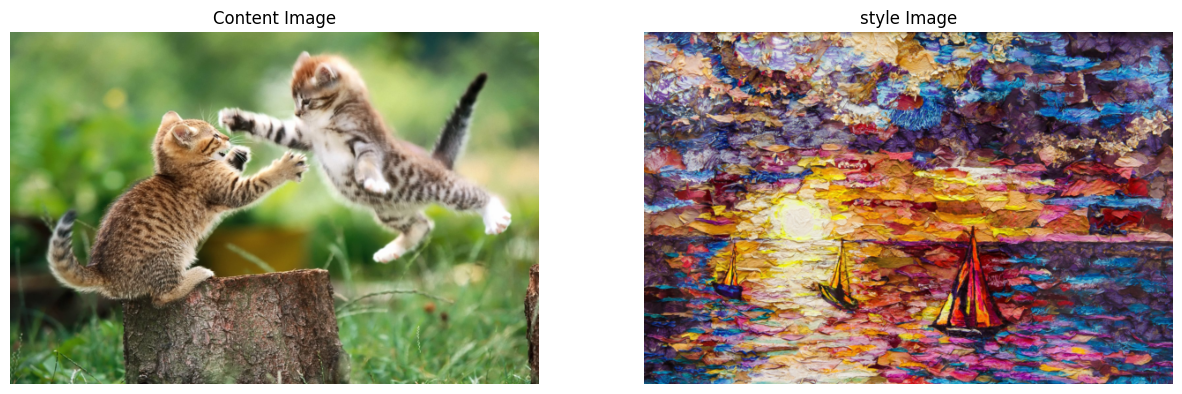

In [173]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(im_convert(content_img))
axs[0].set_title('Content Image')
axs[0].axis('off')

axs[1].imshow(im_convert(style_image))
axs[1].set_title('style Image')
axs[1].axis('off')

plt.show()

In [174]:
optimizer = Adam([generated_img],lr = 0.003)

In [175]:
# Initializing the model
VGG_model = VGG().to(device)

In [176]:
# Defining Gram Matrix
def G_matrix(x, channels, height, width):
    features = x.view(channels, height * width)
    gram = features.mm(features.t())
    return gram


In [177]:
#HyperParameters
alpha = 1
beta = 0.01

Epoch [1/5000]


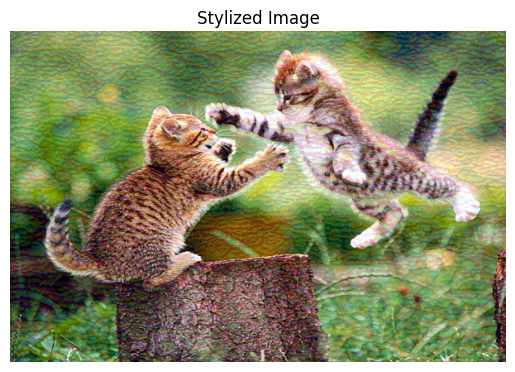

Epoch [1001/5000]


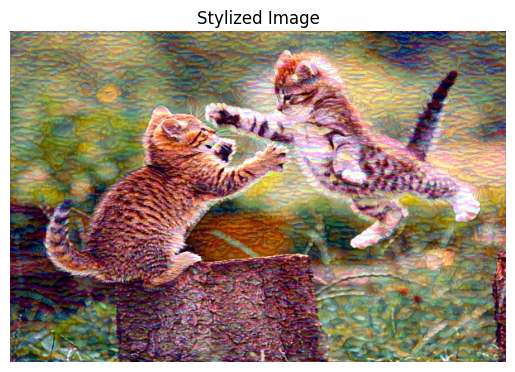

Epoch [2001/5000]


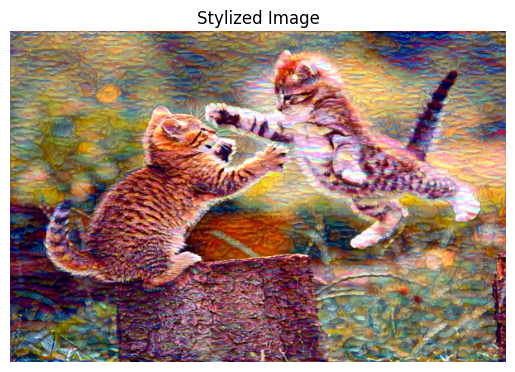

Epoch [3001/5000]


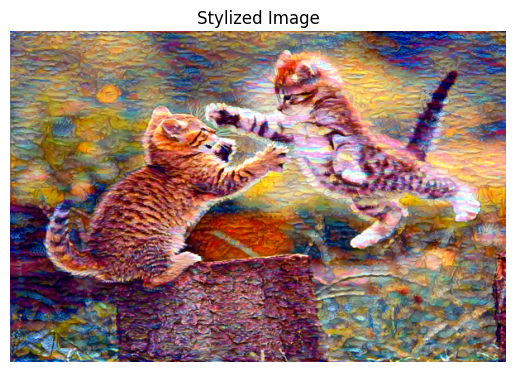

Epoch [4001/5000]


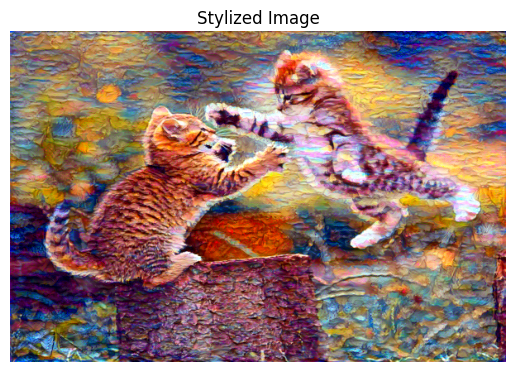

In [ ]:
epochs = 4000
for epoch in range(epochs):
    content_loss = style_loss = total_loss= 0
    A_g = VGG_model(generated_img,21) # passing the generated image through 21st layer
    A_c = VGG_model(content_img,21) # passing the content layer
    content_loss += torch.mean((A_g-A_c)**2)
    
    selected_layers = [0,5,10,19,28]
    style_weights = [2,1.5,1,0.5,0.25]
    for layer in range(5):
        gen = VGG_model(generated_img,selected_layers[layer])
        style = VGG_model(style_image,selected_layers[layer])
        gen_batch , gen_channel , gen_height , gen_width = gen.shape
        style_batch ,style_channel , style_height , style_width = style.shape
        # calculating the gram matrix
        gram_gen = G_matrix(gen,gen_channel,gen_height,gen_width)
        style_gen = G_matrix(style,style_channel,style_height,style_width)
        
        #calculating the loss for this layer
        style_loss_layer = torch.mean((gram_gen-style_gen)**2)
        style_loss += style_weights[layer]*style_loss_layer
    total_loss+= alpha*content_loss + beta*style_loss
    #backward
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    if epoch%1000 ==0:
        print(f'Epoch [{epoch+1}/{epochs}]')
        plt.imshow(im_convert(generated_img))
        plt.title('Stylized Image')
        plt.axis('off')
        plt.show()


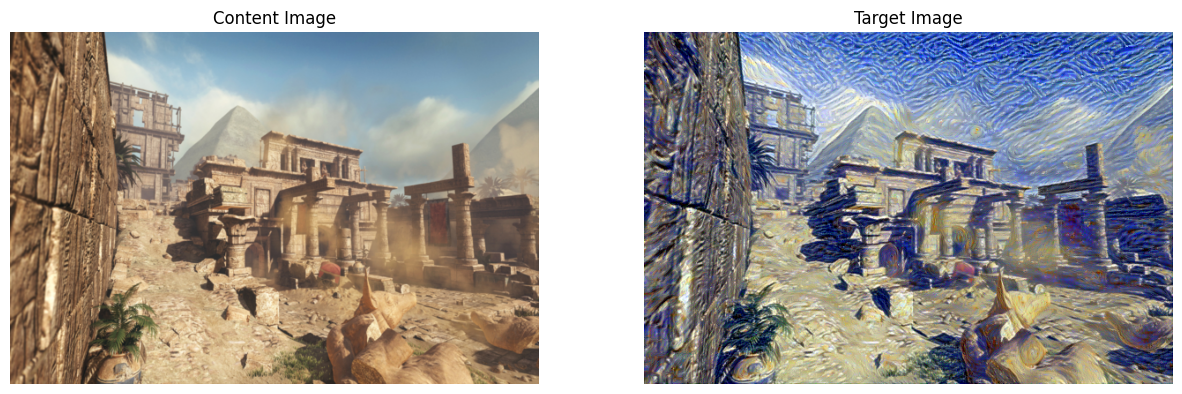

In [151]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(im_convert(content_img))
axs[0].set_title('Content Image')
axs[0].axis('off')

axs[1].imshow(im_convert(generated_img))
axs[1].set_title('Target Image')
axs[1].axis('off')

plt.show()

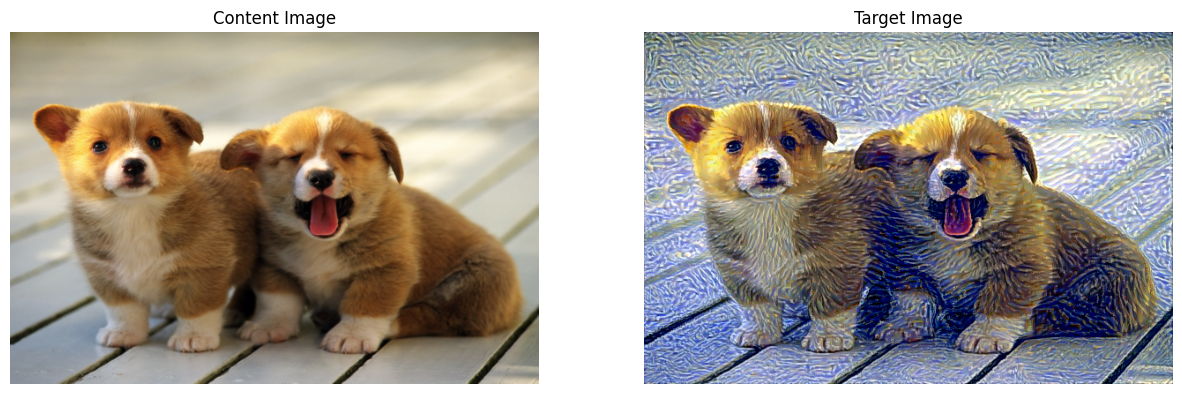

In [160]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(im_convert(content_img))
axs[0].set_title('Content Image')
axs[0].axis('off')

axs[1].imshow(im_convert(generated_img))
axs[1].set_title('Target Image')
axs[1].axis('off')

plt.show()

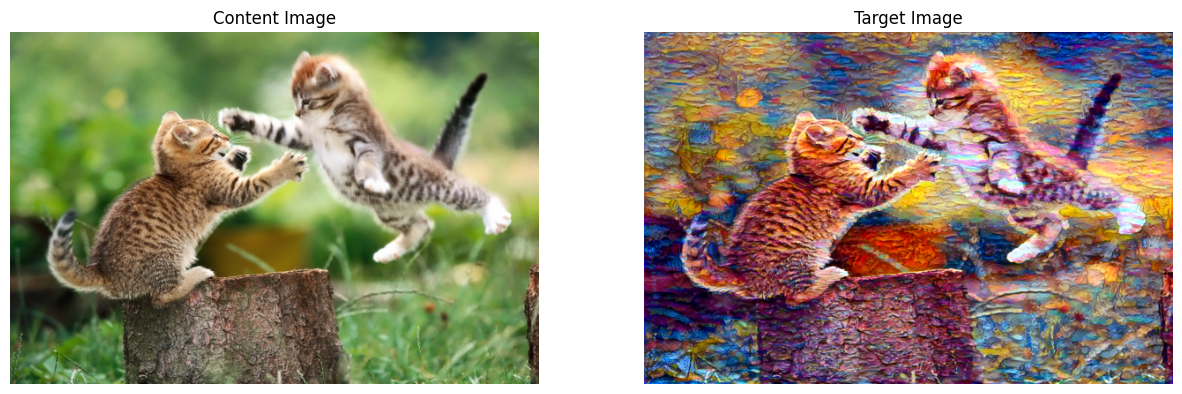

In [184]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(im_convert(content_img))
axs[0].set_title('Content Image')
axs[0].axis('off')

axs[1].imshow(im_convert(generated_img))
axs[1].set_title('Target Image')
axs[1].axis('off')

plt.show()